# Packages

In [ ]:
%pip install dlib
%pip install opencv-python imageio

In [ ]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import Delaunay
from google.colab import files

# Pretrained Models

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2025-01-14 11:13:25--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  40.6MB/s    in 1.5s    

2025-01-14 11:13:26 (40.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



# Upload Images

In [ ]:
from google.colab import files

uploaded = files.upload()

image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # to RGB

Saving artbreeder-image-2025-01-14T04_05_33.492Z.jpeg to artbreeder-image-2025-01-14T04_05_33.492Z (1).jpeg


# Dlib initialization

In [ ]:
detector_static = dlib.get_frontal_face_detector()

predictor_static = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Detecting landmarks


0–16：Jawline (下巴)

17–21：Right Eyebrow (右眉毛)

22–26：Left Eyebrow (左眉毛)

27–35：Nose (鼻子)

36–41：Right Eye (右眼)

42–47：Left Eye (左眼)

48–67：Mouth (嘴巴)

In [ ]:
faces = detector_static(image)

for face in faces:
    landmarks = predictor_static(image, face)

    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    for n in range(68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        cv2.circle(image, (x, y), 2, (255, 0, 0), -1)

        # Labeling
        if n == 30:  # top of the nose
            cv2.putText(image, "Nose", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
        elif n == 36:
            cv2.putText(image, "Right Eye", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
        elif n == 42:
            cv2.putText(image, "Left Eye", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
        elif n == 48:  # left side on the mouth
            cv2.putText(image, "Mouth", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)


# Results

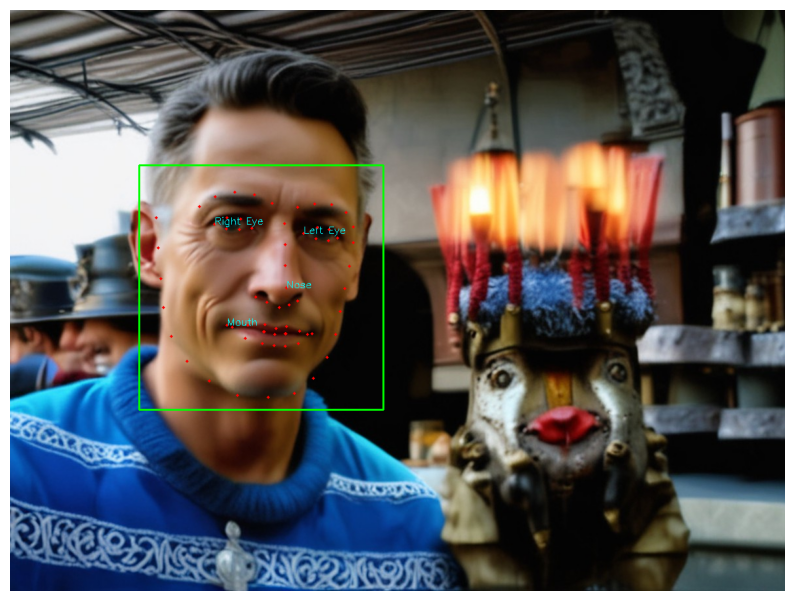

In [ ]:
plt.close('all')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

# Animation (1 second example)

## Upload Images

In [ ]:
# uploaded = files.upload()
# image_path = list(uploaded.keys())[0]
image_path = 'artbreeder-image-2025-01-14T04_05_33.492Z.jpeg'
image_ani = cv2.imread(image_path)
image_ani = cv2.cvtColor(image_ani, cv2.COLOR_BGR2RGB)  # to RGB

## Dlib initialization

In [ ]:
detector_ani = dlib.get_frontal_face_detector()
predictor_ani = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

## Detecting landmarks

In [ ]:
faces_ani = detector_ani(image_ani)
if len(faces_ani) == 0:
    raise ValueError("No faces detected in the uploaded image.")

face_ani = faces_ani[0]

landmarks_ani = predictor_ani(image_ani, face_ani)
points_ani = np.array([(landmarks_ani.part(n).x, landmarks_ani.part(n).y)
                        for n in range(68)], dtype=np.int32)

# Perform Delaunay triangulation for warping
tri = Delaunay(points_ani).simplices

## Helper functions

In [ ]:
def warp_triangle(src_img, dst_img, t1, t2):
    """ Helper function to apply affine transformation for a triangle. """

    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    t1_rect = np.array([[pt[0] - r1[0], pt[1] - r1[1]] for pt in t1], np.float32)
    t2_rect = np.array([[pt[0] - r2[0], pt[1] - r2[1]] for pt in t2], np.float32)
    mask = np.zeros((r2[3], r2[2], 3), dtype=np.uint8)

    cv2.fillConvexPoly(mask, np.int32(t2_rect), (1, 1, 1), 16, 0)
    src_rect = src_img[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]
    warp_mat = cv2.getAffineTransform(t1_rect, t2_rect)
    dst_rect = cv2.warpAffine(src_rect, warp_mat, (r2[2], r2[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    dst_img[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = dst_img[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * (1 - mask) + dst_rect * mask


def animate_expression_to_mp4(src_img, points, offsets, num_frames=30):
    """ Set up the video writer (MP4 format, 30 FPS). """
    height, width, _ = src_img.shape
    out = cv2.VideoWriter(f'expression_animation_{num_frames}_frames.mp4',
                          cv2.VideoWriter_fourcc(*'mp4v'),
                          30,
                          (width, height))

    for t in np.linspace(0, 1, num_frames):
        animated_points = points + (t * offsets).astype(np.int32)

        # Create a new frame
        frame = src_img.copy()
        # for (orig, anim) in zip(points, animated_points):
        #     cv2.circle(frame, tuple(anim), 2, (255, 0, 0), -1)
        for tri_idx in tri:
            t1 = points[tri_idx]
            t2 = animated_points[tri_idx]
            warp_triangle(src_img, frame, t1, t2)

        # Convert frame back to BGR for OpenCV
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)

    out.release()
    print(f"MP4 video saved as 'expression_animation_{num_frames}_frames.mp4'")


def animate_expression(src_img, points, offsets, num_frames=30):
    frames = []
    for t in np.linspace(0, 1, num_frames):  # FPS per 1 sec
        print(f"Processing frame {t}")
        new_points = points + (t * offsets).astype(np.int32)

        frame = src_img.copy()
        for (x, y), (new_x, new_y) in zip(points_ani, new_points):
            # cv2.circle(frame, (int(new_x), int(new_y)), 2, (255, 0, 0), -1)
            cv2.circle(frame, (x, y), 2, (255, 0, 0), -1)

        frames.append(frame)
    return frames

## Animate to mp4

In [ ]:
from google.colab.patches import cv2_imshow

# Define smile offset
# Make sure shape of smile_offset is (68, 2)
offsets = np.zeros((68, 2), dtype=np.int32)
# offsets = np.array(offsets[:68])

# Animate eyes (blinking)
offsets[36:42] = [0, 10/2]  # Right eye
offsets[42:48] = [0, 10/2]  # Left eye

# Animate nose (subtle vertical and horizontal movement)
offsets[27:36] = [5/2, -5/2]  # Nose bridge and base

# Animate lips (smile effect)
offsets[48:54] = [0, -10/2]  # Upper lip moves up
offsets[54:60] = [0, 10/2]   # Lower lip moves down

num_frames = 30  # 1 sec x 30 FPS
animate_expression_to_mp4(
    src_img=image_ani,
    points=points_ani,
    offsets=offsets,
    num_frames=num_frames)

MP4 video saved as 'expression_animation_30_frames.mp4'


## Mp4 to GIF

In [ ]:
import os
# cv2.destroyAllWindows()  # Close window after animation
# Save the animation (optional)
# Optional: Convert to GIF using ffmpeg (requires system installation)

def mp4_to_gif(
    video_path,
    output_gif_path,
    fps=15,
    resize_width=None,
    resize_height=None
):
    """ Converts an MP4 video to a GIF animation. """

    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")

    if fps <= 0:
        raise ValueError("FPS must be a positive value.")

    try:
        vid = cv2.VideoCapture(video_path)
        frames = []
        while(vid.isOpened()):
            ret, frame = vid.read()
            if ret:
                if resize_width is not None and resize_height is not None:
                    frame = cv2.resize(frame, (resize_width, resize_height))

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Important for correct color in GIF
                frames.append(frame)
            else:
                break
        vid.release()

        if not frames:
            print("No frames were read from the video. Check the file or codec.")
            return

        imageio.mimsave(output_gif_path, frames, fps=fps)
        print(f"GIF saved to: {output_gif_path}")

    except Exception as e:
        print(f"An error occurred during conversion: {e}")

# video_filename = f'expression_animation_{num_frames}_frames.mp4'
# gif_filename = f'expression_animation_{num_frames}_frames.gif'
# output_gif_filename = gif_filename

# mp4_to_gif(video_filename,
#            output_gif_filename,
#            fps=15,
#            resize_width=None,
#            resize_height=None)


## Results

In [ ]:
video_filename = f'expression_animation_{num_frames}_frames.mp4'
gif_filename = f'expression_animation_{num_frames}_frames.gif'
output_gif_filename = gif_filename

mp4_to_gif(video_filename,
           output_gif_filename,
           fps=15,
           resize_width=None,
           resize_height=None)

GIF saved to: expression_animation_30_frames.gif


## Preview

In [ ]:
from IPython.display import Image
Image(filename=f'expression_animation_{num_frames}_frames.gif')

Output hidden; open in https://colab.research.google.com to view.